##  Imports and initialze dataframe

In [391]:
import numpy as np
from numpy import interp

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc


df = pd.read_csv("data_for_training.csv")


df.drop([],axis=1)

seed_x = df.drop(['VALUATION TO FUNDING RATIO', 'TOTAL FUNDING USD','AVG REVENUE', 'AVG REVENUE GROWTH', 'AVG EMPLOYEE GROWTH',  'FUNDING UP UNTIL VALUATION DATE',
                 'INDEX', 'Unnamed: 0', 'NAME', 'FUNDING FROM EARLY STAGES'], axis=1)


seed_y = df["VALUATION TO FUNDING RATIO"] > 30

seed_y = seed_y.astype(int)



seed_x.corr(method="spearman").to_csv("corr.csv")



In [360]:
rs = 1
seed_x_train, seed_x_test, seed_y_train, seed_y_test = train_test_split(seed_x,
                                                                        seed_y,
                                                                        test_size=0.2,
                                                                        random_state=rs)


In [361]:
def split_downsample(X, y):
    var = y.name
    #split data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    #combine them back for resampling
    train_data = pd.concat([X_train, y_train], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[var] == 0]
    positive = train_data[train_data[var] == 1]

    # downsample majority
    neg_downsampled = resample(negative,
                               replace=True,  # sample with replacement
                               # match number in minority class
                               n_samples=len(positive),
                               )  # reproducible results

    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    # check new class counts

    new_X_train = upsampled.drop(var, axis=1)
    new_y_train = upsampled[var]

    return new_X_train, X_test, new_y_train, y_test




In [362]:
def downsample(X, y, rs=None):
    var = y.name

    joint = pd.concat([X, y], axis=1)
    negative = joint[joint[var] == 0]
    positive = joint[joint[var] == 1]

    # downsample majority
    neg_downsampled = resample(negative,
                               replace=True,  # sample with replacement
                               # match number in minority class
                               n_samples=len(positive),
                               random_state=rs)  # reproducible results

    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    # check new class counts

    new_X = upsampled.drop(var, axis=1)
    new_y = upsampled[var]

    return new_X, new_y


In [363]:
downsample(seed_x_train, seed_y_train)[1].value_counts()


0    245
1    245
Name: VALUATION TO FUNDING RATIO, dtype: int64

In [364]:
def downsample_split(X, y):
    var = y.name
    #combine them for resampling
    train_data = pd.concat([X, y], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[var] == 0]
    positive = train_data[train_data[var] == 1]

    # downsample majority
    neg_downsampled = resample(negative,
                               replace=True,  # sample with replacement
                               # match number in minority class
                               n_samples=len(positive),
                               )  # reproducible results

    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])

    X_train, X_test, y_train, y_test = train_test_split(
        upsampled.drop(var, axis=1), upsampled[var], stratify=upsampled[var],
        test_size=0.33,)

    # check new class counts
#     print(y_train.value_counts())

    return X_train, X_test, y_train, y_test


In [365]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, SelectKBest


In [366]:
def get_feat(method, k, x, y):
    select = SelectKBest(method,k=k)
    _ = select.fit_transform(x, y)
    return [x.columns[i] for i, val in enumerate(select.get_support()) if val]


In [367]:
num_features = 8


In [368]:
mutual_seed = get_feat(mutual_info_classif, num_features,
                       seed_x_train, seed_y_train)


In [369]:
chi2_seed = get_feat(chi2, num_features, seed_x_train, seed_y_train)


In [370]:
f_seed = get_feat(f_classif, num_features, seed_x_train, seed_y_train)


In [371]:

import statsmodels.api as sm


def logiVarSelect(x, y, sig_lvl, columns):
    while True:
        # The maxiter is increased to help convergence for seed
        logi = sm.Logit(y, x).fit(method='bfgs', maxiter=1000)
        maxP = max(logi.pvalues)
        if maxP > sig_lvl:
            loc = list(logi.pvalues).index(maxP)
            x = np.delete(x, loc, 1)
            columns = np.delete(columns, loc)
        else:
            return columns


In [372]:
selected_columns_seed = seed_x_train.columns.values


SL = 0.05


In [373]:
p_seed = logiVarSelect(seed_x_train.values,
                       seed_y_train.values, SL, selected_columns_seed)


Optimization terminated successfully.
         Current function value: 0.322920
         Iterations: 119
         Function evaluations: 125
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: 0.322920
         Iterations: 118
         Function evaluations: 124
         Gradient evaluations: 124
Optimization terminated successfully.
         Current function value: 0.340046
         Iterations: 69
         Function evaluations: 75
         Gradient evaluations: 75
Optimization terminated successfully.
         Current function value: 0.340066
         Iterations: 64
         Function evaluations: 70
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: 0.340369
         Iterations: 64
         Function evaluations: 70
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: 0.340680
         Iterations: 63
         Function evaluations:

In [374]:
p_seed


array(['VALUATION AVG', 'FUNDING FROM EARLY STAGES > 2M',
       'IS_HEALTH_INDUSTRY', 'IS_FOOD_INDUSTRY',
       'IS_TRANSPORTATION_INDUSTRY',
       'REVENUE MODEL MARKETPLACE & ECOMMERCE',
       'REVENUE MODEL MANUFACTURING', 'REVENUE MODEL SAAS'], dtype=object)

In [375]:
pd.set_option('display.max_colwidth', None)

data = [['P-value', p_seed],
        ['Chi Squared/F-value', chi2_seed],
        ['Mutual information', mutual_seed],
        ]
df = pd.DataFrame(
    data, columns=['Selection Method', 'Seed Selected Variables'])
df


,Selection Method,Seed Selected Variables
0,P-value,"[VALUATION AVG, FUNDING FROM EARLY STAGES > 2M, IS_HEALTH_INDUSTRY, IS_FOOD_INDUSTRY, IS_TRANSPORTATION_INDUSTRY, REVENUE MODEL MARKETPLACE & ECOMMERCE, REVENUE MODEL MANUFACTURING, REVENUE MODEL SAAS]"
1,Chi Squared/F-value,"[VALUATION AVG, FUNDING FROM EARLY STAGES > 2M, IS_HEALTH_INDUSTRY, IS_FOOD_INDUSTRY, IS_TRANSPORTATION_INDUSTRY, REVENUE MODEL MANUFACTURING, REVENUE MODEL SAAS, HQ HELSINKI]"
2,Mutual information,"[VALUATION AVG, FUNDING FROM EARLY STAGES > 2M, IS_FOOD_INDUSTRY, REVENUE MODEL MANUFACTURING, REVENUE MODEL SAAS, HQ STOCKHOLM, HQ OSLO, HQ HELSINKI]"


In [376]:
colors=['red','darkorange','royalblue','blueviolet']

In [377]:
def scikit_logi(X, y, samplemethod):
    # Splits x,y into testing and validation sets, and return the fpr and tpr of the validation set
    X_train, X_test, y_train, y_test = samplemethod(X, y)
    logi = LogisticRegression(solver='lbfgs', max_iter=400)
    model = logi.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    return (fpr, tpr)


In [378]:
def logi_plot_roc(x, y, c, show_detail=False, txtlabel=""):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for i in range(100):
        fpr_R_seed_sel, tpr_R_seed_sel = scikit_logi(x, y, split_downsample)
        if show_detail == True:
            plt.plot(fpr_R_seed_sel, tpr_R_seed_sel,
                     lw=0.1, color=c, alpha=0.6)

        interp_tpr = interp(mean_fpr, fpr_R_seed_sel, tpr_R_seed_sel)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr_R_seed_sel, tpr_R_seed_sel))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=c,
             label=txtlabel +
             r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
             lw=2, alpha=0.8)

    if show_detail == True:
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.3,
                         label=r'$\pm$ 1 std. dev.')
    return(mean_fpr, mean_tpr, mean_auc, std_auc)


In [379]:
def label():
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")


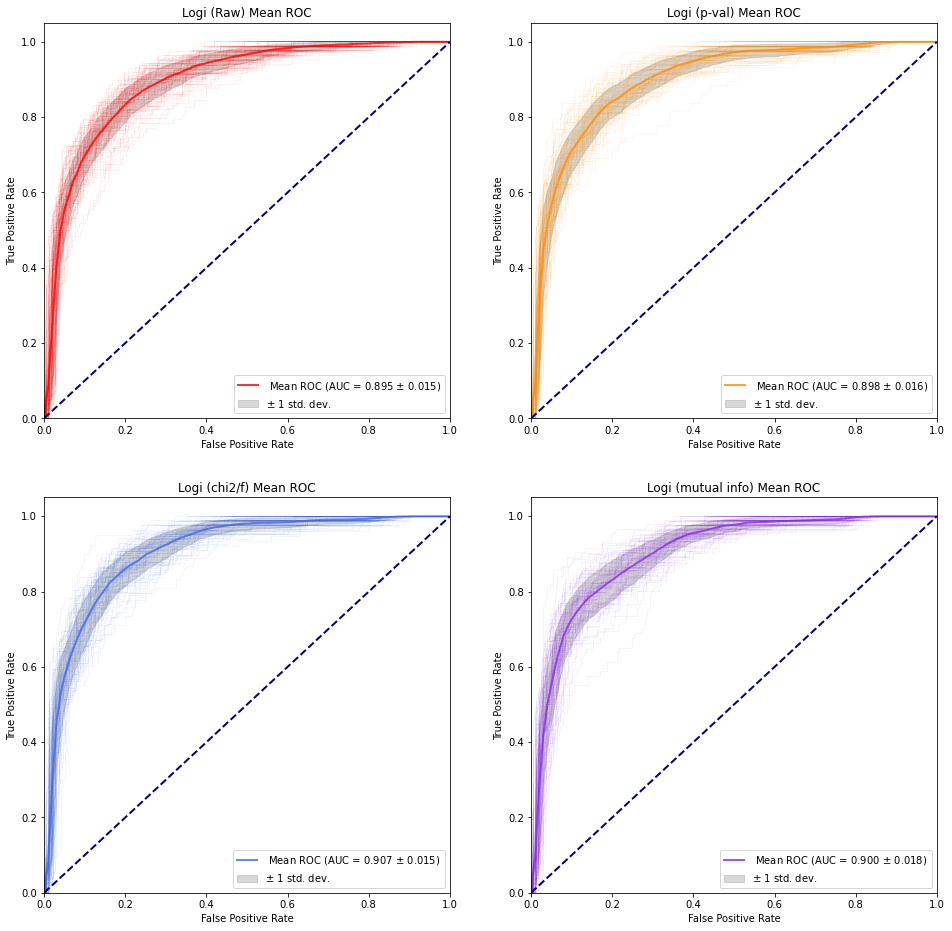

In [380]:
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = fig.add_subplot(2, 2, 1)
c1_mean_fpr, c1_mean_tpr, c1_mean_auc, c1_std_auc = logi_plot_roc(
    seed_x_train, seed_y_train, colors[0], show_detail=True)
label()
plt.title("Logi (Raw) Mean ROC")

ax = fig.add_subplot(2, 2, 2)
c2_mean_fpr, c2_mean_tpr, c2_mean_auc, c2_std_auc = logi_plot_roc(
    seed_x_train[p_seed], seed_y_train, colors[1], show_detail=True)
label()
plt.title("Logi (p-val) Mean ROC")

ax = fig.add_subplot(2, 2, 3)
c3_mean_fpr, c3_mean_tpr, c3_mean_auc, c3_std_auc = logi_plot_roc(
    seed_x_train[chi2_seed], seed_y_train, colors[2], show_detail=True)
label()
plt.title("Logi (chi2/f) Mean ROC")

ax = fig.add_subplot(2, 2, 4)
c4_mean_fpr, c4_mean_tpr, c4_mean_auc, c4_std_auc = logi_plot_roc(
    seed_x_train[mutual_seed], seed_y_train, colors[3], show_detail=True)
label()
plt.title("Logi (mutual info) Mean ROC")
plt.savefig('seed_4x.png')


plt.show()


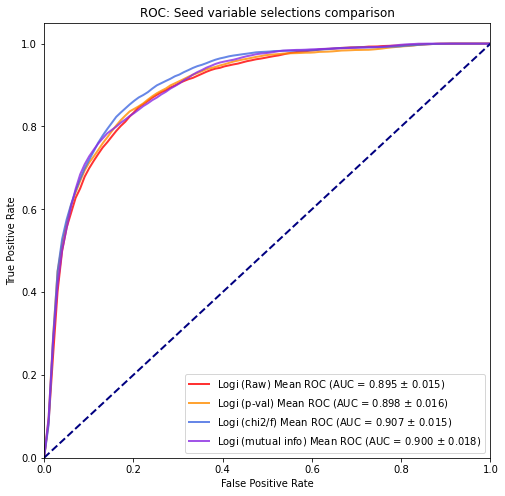

In [381]:
fig = plt.figure(figsize=(8, 8))

plt.plot(c1_mean_fpr, c1_mean_tpr, color=colors[0], label="Logi (Raw)" + r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)'
         % (c1_mean_auc, c1_std_auc), lw=2, alpha=0.8)
plt.plot(c2_mean_fpr, c2_mean_tpr, color=colors[1], label="Logi (p-val)" + r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)'
         % (c2_mean_auc, c2_std_auc), lw=2, alpha=0.8)
plt.plot(c3_mean_fpr, c3_mean_tpr, color=colors[2], label="Logi (chi2/f)" + r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)'
         % (c3_mean_auc, c3_std_auc), lw=2, alpha=0.8)
plt.plot(c4_mean_fpr, c4_mean_tpr, color=colors[3], label="Logi (mutual info)" + r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)'
         % (c4_mean_auc, c4_std_auc), lw=2, alpha=0.8)

label()

plt.title("ROC: Seed variable selections comparison")
plt.savefig('seed_all.png')


plt.show()


In [382]:
def test_results(x_train, y_train, x_test, y_test):
    x_train, y_train = downsample(x_train, y_train,rs)
    logi = LogisticRegression(solver='lbfgs',max_iter=400)
    logi.fit(x_train, y_train)
    acc = logi.score(x_test, y_test)
    y_pred = logi.predict(x_test)
    cm = confusion_matrix(y_test, y_pred,labels=[1, 0])
    tpr = cm[0][0]/np.sum(cm[0])
    tnr = cm[1][1]/np.sum(cm[1])
    return(list(np.round([acc,tpr,tnr],3)))

In [383]:
test_results(seed_x_train, seed_y_train, seed_x_test, seed_y_test)


[0.84, 0.731, 0.865]

In [384]:
test_results(seed_x_train[p_seed], seed_y_train,
             seed_x_test[p_seed], seed_y_test)


[0.862, 0.712, 0.896]

In [385]:
test_results(seed_x_train[chi2_seed], seed_y_train,
             seed_x_test[chi2_seed], seed_y_test)


[0.855, 0.769, 0.874]

In [386]:
test_results(seed_x_train[mutual_seed], seed_y_train,
             seed_x_test[mutual_seed], seed_y_test)


[0.858, 0.788, 0.874]

In [387]:
data = [
    ["Seed Raw"] + test_results(seed_x_train,
                                seed_y_train, seed_x_test, seed_y_test),
    ["Seed P-value"] + test_results(seed_x_train[p_seed],
                                    seed_y_train, seed_x_test[p_seed], seed_y_test),
    ["Seed Chi2/F"] + test_results(seed_x_train[chi2_seed],
                                   seed_y_train, seed_x_test[chi2_seed], seed_y_test),
    ["Seed Mutual"] + test_results(seed_x_train[mutual_seed], seed_y_train, seed_x_test[mutual_seed], seed_y_test)]
df = pd.DataFrame(data, columns=['Method', 'Test Accuracy', 'TPR', "TNR"])
df


,Method,Test Accuracy,TPR,TNR
0,Seed Raw,0.840,0.731,0.865
1,Seed P-value,0.862,0.712,0.896
2,Seed Chi2/F,0.855,0.769,0.874
3,Seed Mutual,0.858,0.788,0.874


In [388]:
logi = sm.Logit(seed_y_train, seed_x_train[chi2_seed]).fit(method='newton',maxiter=1000)

Optimization terminated successfully.
         Current function value: 0.382804
         Iterations 29


In [389]:
print(logi.summary())


                               Logit Regression Results                               
Dep. Variable:     VALUATION TO FUNDING RATIO   No. Observations:                 1125
Model:                                  Logit   Df Residuals:                     1117
Method:                                   MLE   Df Model:                            7
Date:                        Wed, 26 Jan 2022   Pseudo R-squ.:                  0.2696
Time:                                20:44:26   Log-Likelihood:                -430.65
converged:                               True   LL-Null:                       -589.59
Covariance Type:                    nonrobust   LLR p-value:                 9.185e-65
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
VALUATION AVG                      0.0624      0.006     11.143      0.000       0.051       0.073
FUNDING